In [1]:
import caterpillar
from caterpillar import get_critical_path
from datalife import caterpillar as dflg_caterpillar

In [2]:
import networkx as nx
G_raw = nx.read_gpickle('1k_genomes.gpickle')

In [3]:
from collections import Counter

def dict_sum(dlist):
    return dict(sum((Counter(dict(x)) for x in dlist), Counter()))

## Make a graph copy with Task vertices

In [4]:
G_task_only = G_raw.copy()
def get_task_only_graph(G):
    nodes = G.nodes
    new_G = nx.DiGraph()
    for node in nodes:
        #print(node, G.nodes[node]['ntype'])
        iedges = list(G.in_edges(node)) # u,v list of 1-degree
        oedges = list(G.out_edges(node)) # u, v list
        if 'ntype' in G.nodes[node] and 'task' == G.nodes[node]['ntype']:
            # if it is a task node, 
            # find inedges with 2-degree
            inodes = []
            for u, v in iedges: # v is node itself, u is data node
                inodes += G.in_edges(u)
            inodes_to_add = []
            edge_attr_saved = {}
            for u, v in inodes: # v is data node to delete
                inodes_to_add.append((u, node))
                merged_attr = dict_sum([G.get_edge_data(u, v),
                                        G.get_edge_data(v, node)])
                edge_attr_saved[(u, node)] = merged_attr
                #TODO preserve edge attributes
            #new_G.add_edges_from(inodes_to_add)
            # same approach to out edes
            onodes = []
            for u, v in oedges: # u is node itself
                onodes += G.out_edges(v)
            onodes_to_add = []
            for u, v in onodes: # u is data node to delete
                onodes_to_add.append((node, v))
                merged_attr = dict_sum([G.get_edge_data(u, v),
                                        G.get_edge_data(node, u)])
                edge_attr_saved[(node, v)] = merged_attr
            #print(edge_attr_saved)
            #print(merged_attr, inodes_to_add, onodes_to_add)
            #print(len(edge_attr_saved), len(inodes_to_add), len(onodes_to_add))
            new_G.add_edges_from(inodes_to_add)
            new_G.add_edges_from(onodes_to_add)
            for k, v in edge_attr_saved.items():
                new_G.edges[k[0], k[1]].update(v)
            #keep
        else:
            #print(iedges, oedges)
            # If it is a data node,
            # remove itself and connect two lost edges (task nodes)
            edges_to_add = []
            if len(iedges) > 0:
                for u1, v1 in iedges: # v1 is data node
                    for u2, v2 in oedges: # u2 is data node
                        edges_to_add.append((u1, v2))
            new_G.add_edges_from(edges_to_add)
            #delete
    return new_G
    #nx.draw_networkx(new_G)
    #print(new_G.nodes)
g_tasks_only = get_task_only_graph(G_task_only)

In [5]:
labels = {}
for u in G_raw.nodes():
    labels[u] = u.replace(".tar.gz", "")

### Task Only Graph (data vertices hidden)

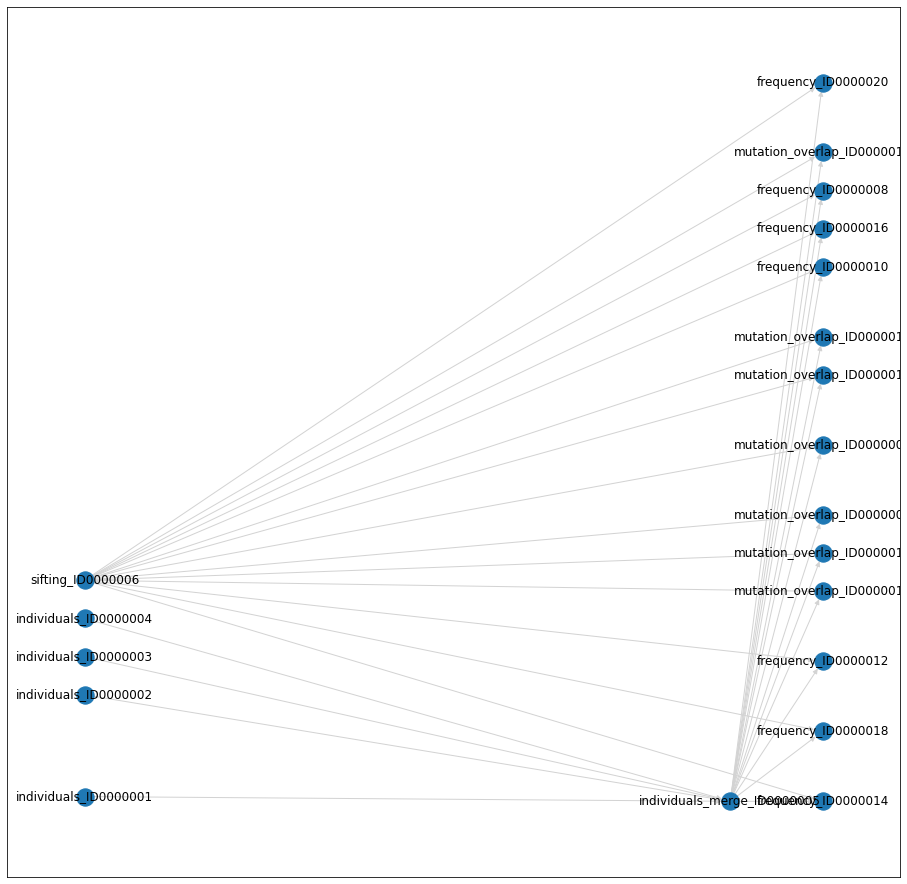

In [6]:
G_copy = G_raw.copy()
import matplotlib.pyplot as plt

plt.figure(3,figsize=(16,16)) 
colors = ['rgb(204,204,204)' for u,v in G_copy.edges()]
pos = nx.get_node_attributes(G_raw,'pos')
nx.draw_networkx(g_tasks_only, pos=pos,  edge_color='lightgrey', style='-')
plt.show()

## 1000 Genomes with two chromosomes

This example shows two independent caterpillar trees extracted after partitioning.

In [7]:
G_2chr = nx.read_gpickle('1kgenome-2chrs.gpickle')

In [8]:
G_2chr_tasks_only = get_task_only_graph(G_2chr)

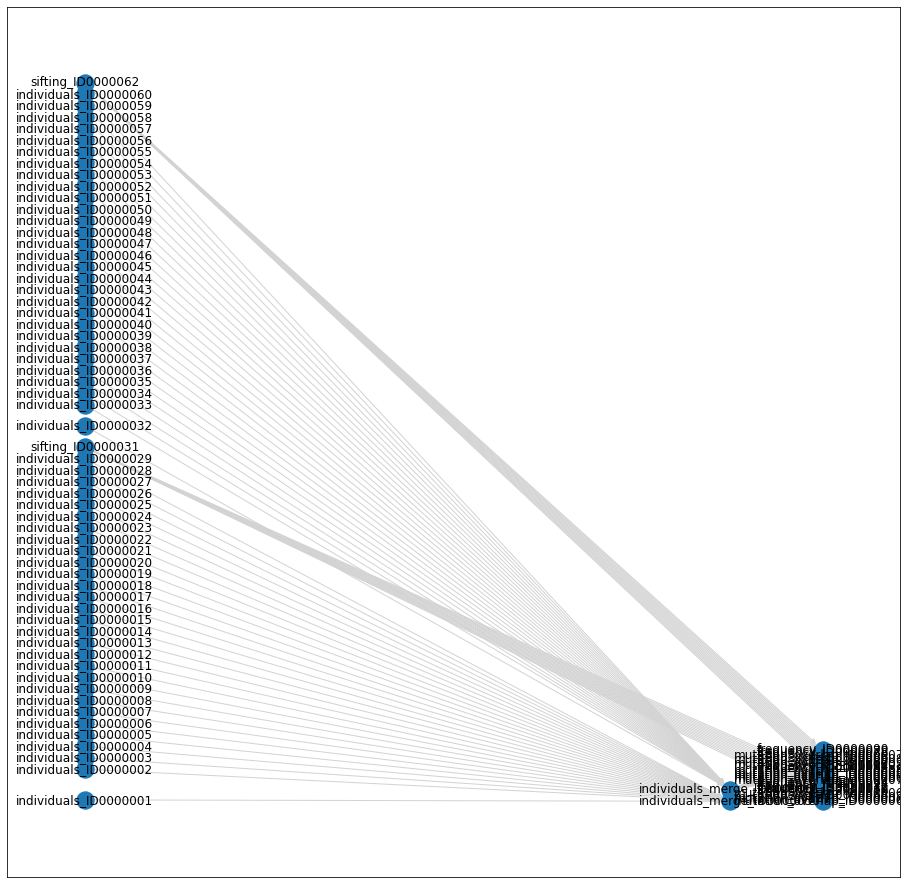

In [9]:
plt.figure(3,figsize=(16,16)) 
colors = ['rgb(204,204,204)' for u,v in G_2chr_tasks_only.edges()]
pos = nx.get_node_attributes(G_2chr,'pos')
nx.draw_networkx(G_2chr_tasks_only, pos=pos,  edge_color='lightgrey', style='-')
plt.show()

In [10]:
cpath = caterpillar.get_critical_path(G_2chr_tasks_only)
cpath

['individuals_ID0000001',
 'individuals_merge_ID0000030',
 'mutation_overlap_ID0000065']

In [11]:
nb_leaves = caterpillar.get_neighbor_leaves(G_2chr_tasks_only, cpath)
ct_graph = caterpillar.caterpillar_tree_in_graph(G_2chr_tasks_only, nb_leaves, weight='value')

In [12]:
gtmp2 = G_2chr_tasks_only.copy()
gtmp2.remove_nodes_from(ct_graph.nodes)

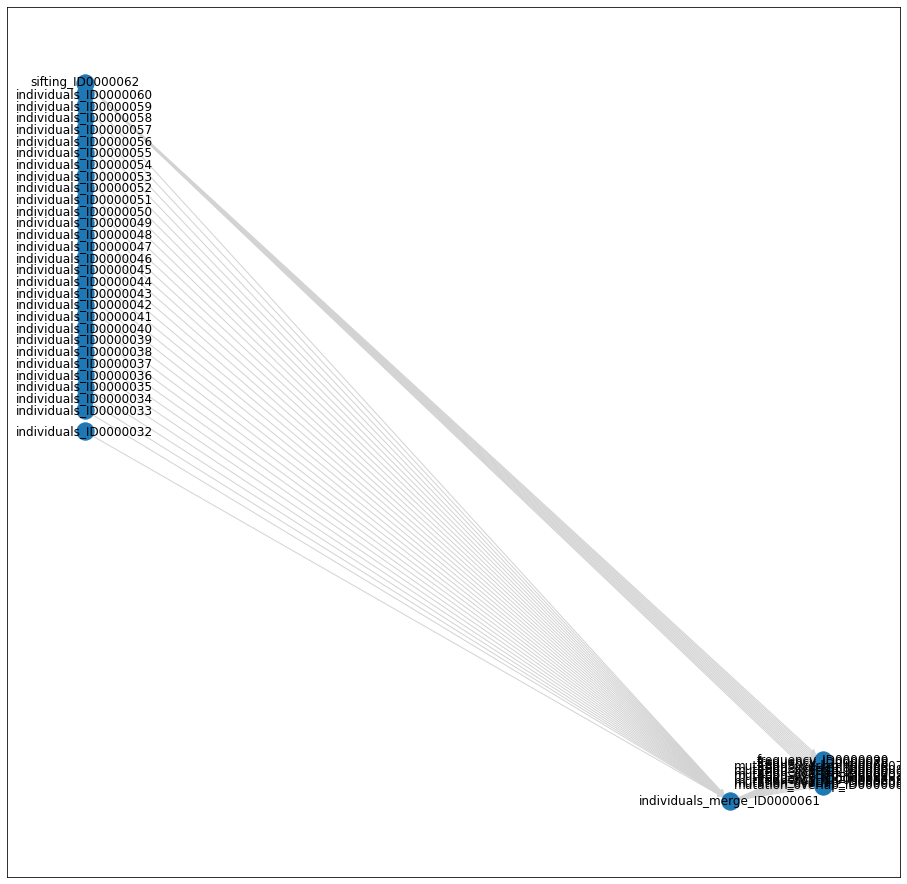

In [13]:
plt.figure(3,figsize=(16,16)) 
colors = ['rgb(204,204,204)' for u,v in gtmp2.edges()]
pos = nx.get_node_attributes(G_2chr,'pos')
nx.draw_networkx(gtmp2, pos=pos,  edge_color='lightgrey', style='-')
plt.show()

In [14]:
cpath2 = caterpillar.get_critical_path(gtmp2)
cpath2

['individuals_ID0000032',
 'individuals_merge_ID0000061',
 'mutation_overlap_ID0000085']

In [15]:
#caterpillar.caterpillar_tree(g2chr_tasks_only)
nb_leaves2 = caterpillar.get_neighbor_leaves(gtmp2, cpath2)
ct_graph2 = caterpillar.caterpillar_tree_in_graph(gtmp2, nb_leaves2, weight='value')
gtmp3 = gtmp2.copy()
gtmp3.remove_nodes_from(ct_graph2.nodes)

In [16]:
gtmp3.nodes

NodeView(())

In [17]:
ct_graph, ct_graph2

(<networkx.classes.digraph.DiGraph at 0x7fe5fdaa1bd0>,
 <networkx.classes.digraph.DiGraph at 0x7fe5fe725490>)

## Resource scheduling and assignment for the prepartion of task deployment

In [18]:
def update_attr(G):
    for u, v, attr in G.edges(data=True):
        attr['weight'] = attr['value']
        G.edges[u, v].update(attr)
    return G
G_2chr_tasks_only_updated = update_attr(G_2chr_tasks_only)

In [19]:
def get_unique_position(pos_dict):
    check = {}
    for k, p in pos_dict.items():
        if p not in check:
            check[p] = {'last_x': [p[0]]}
        else:
            last_x = check[p]['last_x'][-1]
            pos_dict[k] = (last_x + 1, p[1])
            check[p]['last_x'].append(last_x + 1)
            
def get_pos_(G):
    pos = {}
    space = 1
    x = 1
    y = 1
    last_y = 1
    for u, v in G.edges:
        if u in pos:
            x, y = pos[u]
        else:
            y_add = 0
            if v in pos:
                next_x, next_y = pos[v]
                u_attr, v_attr = G.nodes[u], G.nodes[v]
                #print(G.nodes[u], G.nodes[v])
                y_add = (u_attr['ct_level'] - v_attr['ct_level']) * space
                pos[u] = next_x + space , next_y + y_add
            else:
                new_y = last_y - space
                pos[u] = x, new_y
                y = new_y
        if v in pos:
            x, y = pos[v]
        else:
            pos[v] = (pos[u][0], pos[u][1] - space)
            last_y = min(last_y, pos[u][1] - space)
        last_y = min(last_y, y)
    get_unique_position(pos)
    return pos

In [20]:
import random
import numpy as np
from IPython.display import display

default_resource_set = dflg_caterpillar.default_resource_set

def resource_assignment(G, current_queue, res_df=None):
    return bfs_level_sync(G, current_queue)

def bfs_level_sync(G, current_queue):
    while current_queue:
        task_assigned_all = []
        for ct_node in current_queue:
            #print("="*80)
            #print(ct_node)
            #print("="*80)
            required_resources = dflg_caterpillar.resource_required_for_caterpillar(ct_node)
            #print(required_resources)
            # todo 
            # delete
            if required_resources['cpu'] < 1:
                continue
            res_df = get_resource_pool()
            #print(res_df)
            res_avail = request_resource_func(res_df, required_resources)
            #print(res_avail)
            #break
            if len(res_avail) > 0:
                res_df_updated = update_resource_pool(res_df, 'acquisition', res_avail)
                # task assignment
                task_assigned = spawn_ct_tasks(ct_node, res_avail)
                task_assigned_all += task_assigned
                header = "compute_nodename, task_nodename, execution_time (s)"
                #print(header + \
                #      '-' * len(header))
                #print(task_assigned)
                #print(res_df_updated)
                res_df_updated = update_resource_pool(res_df, 'release', res_avail)
                #print(res_df_updated)
            #break
        tmp = pd.DataFrame(task_assigned_all, columns=['compute node', 'task node', 'execution time in second'])
        return tmp
        break

def rand_resource_node(G, resource_grp = default_resource_set):
    resource_res = {}
    for ctree in dflg_caterpillar.task_nodes(G):#G.nodes:
        resource_tmp = {k: 0 for k, v in resource_grp.items()}
        for k, v in resource_grp.items():
            resource_tmp[k] = random.randint(1, int(v))
        resource_res[ctree] = resource_tmp
    nx.set_node_attributes(G, resource_res)
    return G
        
def rand_resource_edge(G, resource_grp = default_resource_set):
    resource_res = {}
    for ctree in G.edges:
        resource_tmp = {k: 0 for k, v in resource_grp.items()}
        for k, v in resource_grp.items():
            resource_tmp[k] = random.randint(1, int(v))
            if 'ntype' in G.nodes[ctree[1]]:
                if k == "data_rate_write":
                    resource_tmp[k] = None
            else:
                if k == "data_rate_read":
                    resource_tmp[k] = None

            #if 'data_rate_write' k
        resource_res[ctree] = resource_tmp
    nx.set_edge_attributes(G, resource_res)
    return G

def rand_exec_time(G, exec_time_grp = {'exec_time_list': [60, 61, 62, 63, 64], #second, 
                                       'upper_bound': 2, # addition,
                                       'lower_bound': 1 # deduction
                                      }):
    time_res = {}
    for ct_node in G.nodes:
        time_tmp = {}
        for k, v in exec_time_grp.items():
            if isinstance(v, list):
                min_v = min(v)
                max_v = max(v)
                len_v = len(v)
                rnd_list = [random.randint(int(min_v), int(max_v)) for x in range(len_v)]
                time_tmp[k] = rnd_list
            else:
                time_tmp[k] = random.randint(1, int(v))
        #estimate = np.mean(time_tmp['exec_time_list']) + time_tmp['upper_bound']
        estimate = get_expected_exec_time(time_tmp)
        time_res[ct_node] = {'estimated_in_second':estimate}
        
    nx.set_node_attributes(G, time_res)
    return G

def get_expected_exec_time(task_attr):
    median = np.median(task_attr['exec_time_list'])
    upper_b = task_attr['upper_bound']
    return median + upper_b
    
def spawn_ct_tasks(ct_node, rdf):
    res = []
    rdf_ = rdf.copy()
    row_cnt = len(rdf_)
    i = 0
    #for task_node, task_attr in ct_node.nodes(data=True):
    for task_node in dflg_caterpillar.task_nodes(ct_node):
        task_attr = ct_node.nodes[task_node]
        rdf__ = rdf_
        for k, v in task_attr.items():
            if k in rdf_:
                rdf__ = rdf__.loc[rdf_[k] >= v]
        if len(rdf__) > 0:
            rdata = rdf__.iloc[0]
            resource_nodename = rdata.name
            # TODO 
            # Check
            exec_time = task_attr['estimated_in_second']#get_expected_exec_time(task_attr)
            task_scheduled = (resource_nodename, task_node, exec_time)
            for k, v in rdata.items():
                rdf__.loc[rdata.name][k] -= rdata[k]
            res.append(task_scheduled)
            i += 1
    return res

def get_resource_pool():
    return res_df

def update_resource_pool(df, rtype, rdf):
    for i in range(len(rdf)):
        rdata = rdf.iloc[i]
        if rtype == 'acquisition':
            for k, v in rdata.items():
                df.loc[rdata.name][k] -= rdata[k]
        elif rtype == 'release':
            for k, v in rdata.items():
                df.loc[rdata.name][k] += rdata[k]
    return df

def request_resource_func(df, rgroup):
    """
    Arguments:
        rgroup (dict): required resources
    Returns:
        res (DataFrame): available resource (row)
    """
    res = df
    #print(rgroup)
    for resource_element in res.columns.to_list():
        v = rgroup[resource_element]
        res = res.loc[df[resource_element] >= v]
        #print(res, resource_element, v)
    #print("#", res)
    return res#res.iloc[0]


def slurm_script(df):
    res = []
    for x in df.iterrows():
        try:
            cpus = tasks[x[1]['task node']]['cpu']
        except:
            continue
        cmd = 'srun --nodelist={} --cpus-per-task={} python {}'.format(x[1]['compute node'], cpus, x[1]['task node'])
        res.append(cmd)
    return res

In [21]:
def set_node_cpu(G, G_task_only, resource_grp = {'cpu': 1}):
    resource_res = {}
    for ctree in G_task_only.nodes:#G.nodes:
        resource_tmp = {k: 0 for k, v in resource_grp.items()}
        for k, v in resource_grp.items():
            resource_tmp[k] = 1
            resource_tmp['ntype'] = 'task'
        resource_res[ctree] = resource_tmp
    nx.set_node_attributes(G, resource_res)
    return G
c = set_node_cpu(G_2chr, ct_graph)
c2 = set_node_cpu(G_2chr, ct_graph2)

In [22]:
chr2_queue = [ct_graph, ct_graph2]
idx = 1
for ctree in chr2_queue:
    ctree.name = f"ctree_{idx}"
    idx += 1

In [23]:
default_resource_set = dflg_caterpillar.default_resource_set
default_resource_set

{'cpu': 32,
 'data_rate_write': 300,
 'data_rate_read': 3000,
 'data_volume': 1048576}

In [24]:
genome_write_byte_rate = { # producer, data
                          ('individuals', 'chromosome1'): [ 11977.1471,23264.36473,34393.98515,45535.2282,55893.41144,66603.33706,76809.04354,86661.11632,96428.36142,104977.6476,113137.6417,123194.7986,132683.0407,142497.91,151262.0237,160630.1877,167082.4764,199879.9549,208981.5641,188226.5247,223405.8588,230937.7748,202813.1907,232619.1915,436856.3269,446153.7987,462163.6141,473495.8426,492847.8833],
                          ('individuals_merge', 'output_filename'): [2118.827566], # data vertex filename??
                          ('shifting', 'output_filename'): [4580707.679],          # data vertex filename?? mutations_overlap or frequency??
                          ('frequency', 'output_filename'): [3321161.204,          # data vertex filename??
                                                        6656720.845,9574342.111,12847440.56,16250012.58,19596255.03,23143087.42],
                          ('mutation_overlap', 'output_filename'): [65867519.55,  # data vertex filename?? 'shifting or individuals_merge',
                                                             82322209.91,145987033,212531592.8,281327330.8,350326521.7,529030354.4]
                         }
                          
genome_read_byte_rate = { # data, consumer
                          ('chromosome1', 'individuals',): [ 223056226.17,324867188.65,426677704.32,529984018.67,624703427.41,723423603.33,817132133.38,907309045.30,997276362.68,1074932303.64,1148751196.43,1242072490.13,1329958961.83,1421262837.75,1502191717.22,1589070714.10,1647237768.52,1964249252.22,2048214602.12,1840142735.02,2178941711.31,2247647502.23,1970199086.00,2255993509.68,4229844082.48,4312752320.11,4461209496.01,4564792857.95,492847.88],
                          ('input_filename', 'individuals_merge'): [61592.71211],
                          ('input_filename', 'shifting'):[41054275.98],
                          ('input_filename', 'frequency'): [3321161.204,6656720.845,9574342.111,12847440.56,16250012.58,19596255.03,23143087.42],
                          ('input_filename', 'mutation_overlap'): [7617331.392,9563439.178,17163812.4,24775697.66,32410486.9,40028035.21,48020739.44]
                        }


In [25]:
genome_write_byte_rate_by_key = {}
for u,v in genome_write_byte_rate.keys():
    genome_write_byte_rate_by_key[u] = genome_write_byte_rate[(u,v)]
genome_read_byte_rate_by_key = {}
for u,v in genome_read_byte_rate.keys():
    genome_read_byte_rate_by_key[v] = genome_read_byte_rate[(u,v)]

In [26]:
def set_resource_edge(G, G_task_only, genome_write_byte_rate_by_key, genome_read_byte_rate_by_key):
    resource_res = {}
    idx = 0
    for ctree_task in G_task_only.nodes:
        task_name = ctree_task.split("_ID")[0]
        # write
        if task_name in genome_write_byte_rate_by_key:
            for oedges in G.out_edges(ctree_task):
                try:
                    data_rate_write = genome_write_byte_rate_by_key[task_name][idx]
                    idx += 1
                except:
                    idx = 0
                    data_rate_write = genome_write_byte_rate_by_key[task_name][idx]
                    idx += 1
                G.edges[oedges[0], oedges[1]].update({'data_rate_write': data_rate_write})            
        # read
        idx = 0
        if task_name in genome_read_byte_rate_by_key:
            for iedges in G.in_edges(ctree_task):
                try:
                    data_rate_read = genome_read_byte_rate_by_key[task_name][idx]
                    idx += 1
                except:
                    idx = 0
                    data_rate_read = genome_read_byte_rate_by_key[task_name][idx]
                G.edges[iedges[0], iedges[1]].update({'data_rate_read': data_rate_read})               
    return G
set_resource_edge(G_2chr, ct_graph,genome_write_byte_rate_by_key, genome_read_byte_rate_by_key)

In [27]:
import pandas as pd
def producer(G, G_task_only):
    data = {}
    for node in G_task_only.nodes:
        oedges = G.out_edges(node)
        for u, v in oedges:
            attr = G.edges[u, v]
            data[(u, v)] = attr
    df = pd.DataFrame.from_dict(data, orient='index')
    return df
def consumer(G, G_task_only):
    data = {}
    for node in G_task_only.nodes:
        iedges = G.in_edges(node)
        for u, v in iedges:
            attr = G.edges[u, v]
            data[(u, v)] = attr
    df = pd.DataFrame.from_dict(data, orient='index')
    return df

In [28]:
producer(G_2chr, ct_graph)

,,value,width,frequency_sum,data_rate_write
individuals_ID0000002,chr1n-2-3.tar.gz,2182821,8,47,11977.147100
individuals_merge_ID0000030,chr1n.tar.gz,2177510,8,47,2118.827566
individuals_ID0000020,chr1n-20-21.tar.gz,2182915,8,47,45535.228200
individuals_ID0000003,chr1n-3-4.tar.gz,2185970,8,47,34393.985150
individuals_ID0000017,chr1n-17-18.tar.gz,2180706,8,47,34393.985150
individuals_ID0000004,chr1n-4-5.tar.gz,2176946,8,47,45535.228200
individuals_ID0000023,chr1n-23-24.tar.gz,2181975,8,47,34393.985150
individuals_ID0000026,chr1n-26-27.tar.gz,2191657,8,47,34393.985150
individuals_ID0000007,chr1n-7-8.tar.gz,2184325,8,47,34393.985150
individuals_ID0000010,chr1n-10-11.tar.gz,2180706,8,47,45535.228200


In [29]:
consumer(G_2chr, ct_graph)

,,value,width,frequency_sum,data_rate_read
ALL.chr1.250000.vcf,individuals_ID0000002,22855105892,8,2789933,2.230562e+08
columns.txt,individuals_ID0000002,177812,8,25,3.248672e+08
chr1n-18-19.tar.gz,individuals_merge_ID0000030,9910890,8,213,6.159271e+04
chr1n-25-26.tar.gz,individuals_merge_ID0000030,9895341,8,213,6.159271e+04
chr1n-15-16.tar.gz,individuals_merge_ID0000030,9868503,8,213,6.159271e+04
...,...,...,...,...,...
columns.txt,individuals_ID0000001,177812,8,25,3.248672e+08
ALL.chr1.phase3_shapeit2_mvncall_integrated_v5.20130502.sites.annotation.vcf,sifting_ID0000031,14224308815,8,1736369,NaN
sifted.SIFT.chr1.txt,mutation_overlap_ID0000065,4925368,8,602,7.617331e+06
chr1n.tar.gz,mutation_overlap_ID0000065,8293070,8,179,9.563439e+06


[guol678@bluesky io-concurrent]$ cat concurrent-posix-io-2023-08-09T11:25-0700-iozone.log

* iozone: /qfs/projects/oddite/lenny/iozone/iozone3_506/src/current/iozone

* iozone write: -i 0      -i 2 -s 1g -r  1m -+r -t

* iozone read : -i 0 -i 1 -i 2 -s 1g -r 16k -+r -t

* hostname (local): node03.local

* file system (local): /qfs/projects/oddite/lenny/io-bench/io-concurrent

IOZone notes (cf. 'iozone_w_opts' and 'ior_r_opts')

- Each round is a pair of tests, a "write" and then a "read"

  test. Note that because of IOZone's test structure, there is much

  overlap between the two tests.

- Each test includes two lines of output. An individual test includes

  both read and write tests, e.g., a must always includes a write to

  populate file.

- The final outpu parser selects a subset of the IOZone output:

  - wr-1,rd: write new file (incl all metadata costs); then read (sequential)

  - rnd/w,r: random write; then random read

- 2023-08-09T11:25-0700

   write   1 wr-1,rd:      46.2 MB/s (  46.23/ps)       0.0 MB/s (   0.00/ps)

   write   1 rnd/w,r:      61.1 MB/s (  61.09/ps)    7478.5 MB/s (7478.51/ps)

    read   1 wr-1,rd:       5.7 MB/s (   5.66/ps)    6448.2 MB/s (6448.16/ps)

    read   1 rnd/w,r:       6.2 MB/s (   6.22/ps)    5637.8 MB/s (5637.77/ps)

   write   2 wr-1,rd:      96.1 MB/s (  48.06/ps)       0.0 MB/s (   0.00/ps)

   write   2 rnd/w,r:      94.1 MB/s (  47.06/ps)   13674.5 MB/s (6837.23/ps)

    read   2 wr-1,rd:      11.0 MB/s (   5.52/ps)   13774.4 MB/s (6887.22/ps)

    read   2 rnd/w,r:      12.4 MB/s (   6.20/ps)   11861.8 MB/s (5930.89/ps)

   write   4 wr-1,rd:      99.2 MB/s (  24.79/ps)       0.0 MB/s (   0.00/ps)

   write   4 rnd/w,r:     106.9 MB/s (  26.73/ps)   24509.5 MB/s (6127.37/ps)

    read   4 wr-1,rd:      19.6 MB/s (   4.90/ps)   19460.8 MB/s (4865.19/ps)

    read   4 rnd/w,r:      14.8 MB/s (   3.71/ps)   14901.1 MB/s (3725.28/ps)

   write   8 wr-1,rd:     111.7 MB/s (  13.97/ps)       0.0 MB/s (   0.00/ps)

   write   8 rnd/w,r:     108.6 MB/s (  13.57/ps)   50822.4 MB/s (6352.80/ps)

    read   8 wr-1,rd:      32.7 MB/s (   4.09/ps)   46752.3 MB/s (5844.03/ps)

    read   8 rnd/w,r:      40.5 MB/s (   5.07/ps)   39911.2 MB/s (4988.89/ps)

   write  16 wr-1,rd:     118.1 MB/s (   7.38/ps)       0.0 MB/s (   0.00/ps)

   write  16 rnd/w,r:     117.7 MB/s (   7.36/ps)   75295.3 MB/s (4705.96/ps)

    read  16 wr-1,rd:      56.6 MB/s (   3.54/ps)   74291.4 MB/s (4643.21/ps)

    read  16 rnd/w,r:      52.1 MB/s (   3.25/ps)   69332.4 MB/s (4333.28/ps)

   write  32 wr-1,rd:     118.2 MB/s (   3.69/ps)       0.0 MB/s (   0.00/ps)

   write  32 rnd/w,r:     118.3 MB/s (   3.70/ps)   90948.9 MB/s (2842.15/ps)

    read  32 wr-1,rd:      72.7 MB/s (   2.27/ps)   94461.1 MB/s (2951.91/ps)

In [30]:
# cat /proc/cpuinfo |grep pro|wc -l
# 24
#
# df -h|grep projects
# qfsi:/projects            1.5P  1.3P  123T  92% /qfs/projects
#
#
# 
res_dict = {'bluesky_node03': [24, 118.3e6, 94461e6, 123e12, 3600]}
# TODO
# allocated time length to each compute row? accounting purpose for used and allocated
res_df = pd.DataFrame.from_dict(res_dict, orient='index',
                       columns=['cpu', 'max_rate_w', 'max_rate_r', 'volume', 'allocated time'])
res_capacity = res_df.copy()
res_df

,cpu,max_rate_w,max_rate_r,volume,allocated time
bluesky_node03,24,118300000.0,9.446100e+10,1.230000e+14,3600


In [31]:
res_dict = {'bluesky_node02': [24, 118.3e6, 94461e6, 123e12, 3600],
           'bluesky_node03': [24, 118.3e6, 94461e6, 123e12, 3600]}
res_availability2 = pd.DataFrame.from_dict(res_dict, orient='index',
                       columns=['cpu', 'max_rate_w', 'max_rate_r', 'volume', 'allocated time'])
res_availability2

,cpu,max_rate_w,max_rate_r,volume,allocated time
bluesky_node02,24,118300000.0,9.446100e+10,1.230000e+14,3600
bluesky_node03,24,118300000.0,9.446100e+10,1.230000e+14,3600


In [32]:
def get_jobqueue(G):
    jqueue = []
    tasks = caterpillar.get_roots(G)
    jqueue.append(tasks)    
    next_tasks = [] # remove duplicate later
    current_queue = tasks[::-1]
    added = {} # 'mutation_overlap_ID0000065' duplicated between 2nd and 3rd stages
    while current_queue:
        task = current_queue.pop()
        oedges = G.out_edges(task)
        #print(task, oedges)
        for u, v in oedges:
            if v not in added:
                next_tasks.append(v)
            added[v] = True
            #print(next_tasks)
        #print("==", len(current_queue), len(oedges))
        if len(current_queue) == 0:
            tmp = list(set(next_tasks))
            current_queue = tmp[::-1]
            jqueue.append(tmp)
            next_tasks = []
            #print("++", jqueue, len(current_queue))
    return jqueue
job_queue =get_jobqueue(chr2_queue[0])
job_queue

# 29 individuals and sifting_ID0000031 (30 total) start first
# Q. mutation_overlap_ID0000065 has 2 depths from roots, which explains 3rd steps to run but in the 2nd
# A. will be adjusted in resource assignment, this is pre-conditioning
# A. or we can add length (depth) check 

[['individuals_ID0000002',
  'individuals_ID0000020',
  'individuals_ID0000003',
  'individuals_ID0000017',
  'individuals_ID0000004',
  'individuals_ID0000023',
  'individuals_ID0000026',
  'individuals_ID0000007',
  'individuals_ID0000010',
  'individuals_ID0000022',
  'individuals_ID0000012',
  'individuals_ID0000014',
  'individuals_ID0000009',
  'individuals_ID0000016',
  'individuals_ID0000013',
  'individuals_ID0000006',
  'individuals_ID0000025',
  'individuals_ID0000021',
  'individuals_ID0000008',
  'individuals_ID0000011',
  'individuals_ID0000005',
  'individuals_ID0000029',
  'individuals_ID0000018',
  'individuals_ID0000015',
  'individuals_ID0000024',
  'individuals_ID0000027',
  'individuals_ID0000028',
  'individuals_ID0000019',
  'individuals_ID0000001',
  'sifting_ID0000031'],
 ['individuals_merge_ID0000030', 'mutation_overlap_ID0000065'],
 ['frequency_ID0000068',
  'frequency_ID0000064',
  'frequency_ID0000070',
  'frequency_ID0000072',
  'mutation_overlap_ID0000063

In [33]:
def num_of_cpu_required(G, job_queue):

    max_cpu_cnt = 0
    for job in job_queue:
        cpu_cnt = 0
        for task in job:
            cpu_cnt += G.nodes[task]['cpu']
        max_cpu_cnt = max(max_cpu_cnt, cpu_cnt)
    return max_cpu_cnt

num_of_cpu_required(G_2chr, job_queue)

30

In [34]:

import pandas as pd
def producer_2(G, G_task_only):
    data = {}
    for node in G_task_only.nodes:
        oedges = G.out_edges(node)
        for u, v in oedges:
            attr = G.edges[u, v]
            attr['u'] = u
            attr['v'] = v
            data[(u, v)] = attr
    df = pd.DataFrame.from_dict(data, orient='index')
    return df
def consumer_2(G, G_task_only):
    data = {}
    for node in G_task_only.nodes:
        iedges = G.in_edges(node)
        for u, v in iedges:
            attr = G.edges[u, v]
            attr['u'] = u
            attr['v'] = v
            data[(u, v)] = attr
    df = pd.DataFrame.from_dict(data, orient='index')
    return df

def bandwidth_required(G, G_task_only, job_queue):
    p_df = producer_2(G, G_task_only)
    c_df = consumer_2(G, G_task_only)

    max_w = 0
    max_r = 0
    for job in job_queue:
        write_size = []
        read_size = []
        for task in job:
            # producer (write)
            #print(p_df[p_df['u'] == task])
            #print(p_df[p_df['u'] == task]['data_rate_write'].sum())
            tmp = p_df[p_df['u'] == task]['data_rate_write'].sum()
            write_size.append(tmp)
            # consumer (read)
            tmp = c_df[c_df['v'] == task]['data_rate_read'].sum()
            read_size.append(tmp)            
        #print(write_size)
        max_w = max(max_w, sum(write_size))
        max_r = max(max_r, sum(read_size)) 
    return max_w, max_r
        
bandwidth_required(G_2chr, chr2_queue[0], job_queue)
    

(1064138.6756999998, 15889779029.779993)

In [35]:
def update_resource_pool(df, rtype, rdf, r_node):
    for i in range(len(rdf)):
        rdata = rdf.iloc[i]       
        # TODO; remove 0 index
        if len(r_node) < 1:
            return None
        r_node = r_node.iloc[0]
        if rtype == 'acquisition':
            for k, v in rdata.items():
                tmp =  df.loc[r_node.name, k] - rdata[k]
                if tmp < 0:
                    return None
                df.loc[r_node.name, k] = tmp

        elif rtype == 'release':
            # TODO ; fixed upper limit is lost
            for k, v in rdata.items():
                tmp = df.loc[r_node.name, k] + rdata[k]
                df.loc[r_node.name, k] = tmp
    return df

def request_resource_func(df, rgroup):
    """
    Arguments:
        rgroup (dict): required resources
    Returns:
        res (DataFrame): available resource (row)
    """
    res = df
    #print(rgroup)
    for resource_element in res.columns.to_list():
        v = rgroup[resource_element]
        res = res.loc[df[resource_element] >= float(v)]
        #print(res, resource_element, v)
    #print("#", res)
    return res#res.iloc[0]

def resource_assignment(G, jqueue, res_df, priority='cpu'):

    scheduled = {}
    for jobs in jqueue:
        for job in jobs:
            scheduled[job] = False
    assigned_q = []
    if len(jqueue) == 0:
        return
    jqueue_idx = 0
    current_queue = jqueue[jqueue_idx][::-1]
    res_copy = res_df.copy()
    tasks_scheduled = []
    while current_queue:
        #FIFO in the same set
        task = current_queue.pop()
        #print(task)
        # Q. higher # of cpus assign first?
        if priority == "cpu":
            #print(task)
            cpu_cnt = G.nodes[task]['cpu']            
            #print(res_copy)
            requested =  pd.DataFrame.from_dict({'cpu': [cpu_cnt], 'max_rate_w':[0], 'max_rate_r':[0], 'volume':[0], 'allocated time':[0]})
            #print(requested)
            #update_resource_pool(res_copy, requested, inplace=True)
            r_node = request_resource_func(res_copy, requested)
            d = pd.DataFrame()
            if len(r_node) != 0:
                d = update_resource_pool(res_copy, 'acquisition', requested, r_node)
            else:
                # put a task back to queue
                #print("=", task, d.empty)
                current_queue.append(task)
            #print(r_node)
            if not d.empty:
                scheduled[task] = len(assigned_q)
                tasks_scheduled.append((task, r_node.iloc[0].name, cpu_cnt))
            else:
                # move to next cycle if out of resources
                assigned_q.append(tasks_scheduled)
                tasks_scheduled = []
                res_copy = res_df.copy()
            if len(current_queue) < 1:
                jqueue_idx += 1
                current_queue = jqueue[jqueue_idx][::-1]
                if len(tasks_scheduled) != 0:
                    assigned_q.append(tasks_scheduled)
                    tasks_scheduled = []
    
    if len(tasks_scheduled) != 0:
        assigned_q.append(tasks_scheduled)
        tasks_scheduled = []

    return scheduled, assigned_q
resource_assignment(G_2chr, job_queue, res_df)
# returns scheduled, with sequence order
# assigned_q for node name
# maybe UML to display?

({'individuals_ID0000002': 0,
  'individuals_ID0000020': 0,
  'individuals_ID0000003': 0,
  'individuals_ID0000017': 0,
  'individuals_ID0000004': 0,
  'individuals_ID0000023': 0,
  'individuals_ID0000026': 0,
  'individuals_ID0000007': 0,
  'individuals_ID0000010': 0,
  'individuals_ID0000022': 0,
  'individuals_ID0000012': 0,
  'individuals_ID0000014': 0,
  'individuals_ID0000009': 0,
  'individuals_ID0000016': 0,
  'individuals_ID0000013': 0,
  'individuals_ID0000006': 0,
  'individuals_ID0000025': 0,
  'individuals_ID0000021': 0,
  'individuals_ID0000008': 0,
  'individuals_ID0000011': 0,
  'individuals_ID0000005': 0,
  'individuals_ID0000029': 0,
  'individuals_ID0000018': 0,
  'individuals_ID0000015': 0,
  'individuals_ID0000024': 1,
  'individuals_ID0000027': 1,
  'individuals_ID0000028': 1,
  'individuals_ID0000019': 1,
  'individuals_ID0000001': 1,
  'sifting_ID0000031': 1,
  'individuals_merge_ID0000030': 2,
  'mutation_overlap_ID0000065': 2,
  'frequency_ID0000068': 3,
  'fr

In [36]:
def resource_assignment_ctree(G, cforest):
    res = {}
    for ctree in cforest:
        job_queue = get_jobqueue(ctree)
        res_df = res_availability2
        scheduled, assigned_q = resource_assignment(G, job_queue, res_df)
        res[ctree.name] = [scheduled, assigned_q]
        #print(assigned_q)
        #print(job_queue)
    return res
        
res = resource_assignment_ctree(G_2chr, chr2_queue)
tasks_assigned = [v[1] for k, v in res.items()]
#tasks_assigned
tasks_scheduled = [v[0] for k, v in res.items()]
tasks_scheduled

[{'individuals_ID0000002': 0,
  'individuals_ID0000020': 0,
  'individuals_ID0000003': 0,
  'individuals_ID0000017': 0,
  'individuals_ID0000004': 0,
  'individuals_ID0000023': 0,
  'individuals_ID0000026': 0,
  'individuals_ID0000007': 0,
  'individuals_ID0000010': 0,
  'individuals_ID0000022': 0,
  'individuals_ID0000012': 0,
  'individuals_ID0000014': 0,
  'individuals_ID0000009': 0,
  'individuals_ID0000016': 0,
  'individuals_ID0000013': 0,
  'individuals_ID0000006': 0,
  'individuals_ID0000025': 0,
  'individuals_ID0000021': 0,
  'individuals_ID0000008': 0,
  'individuals_ID0000011': 0,
  'individuals_ID0000005': 0,
  'individuals_ID0000029': 0,
  'individuals_ID0000018': 0,
  'individuals_ID0000015': 0,
  'individuals_ID0000024': 0,
  'individuals_ID0000027': 0,
  'individuals_ID0000028': 0,
  'individuals_ID0000019': 0,
  'individuals_ID0000001': 0,
  'sifting_ID0000031': 0,
  'individuals_merge_ID0000030': 1,
  'mutation_overlap_ID0000065': 1,
  'frequency_ID0000068': 2,
  'fr

In [37]:
tasks_assigned

[[[('individuals_ID0000002', 'bluesky_node02', 1),
   ('individuals_ID0000020', 'bluesky_node02', 1),
   ('individuals_ID0000003', 'bluesky_node02', 1),
   ('individuals_ID0000017', 'bluesky_node02', 1),
   ('individuals_ID0000004', 'bluesky_node02', 1),
   ('individuals_ID0000023', 'bluesky_node02', 1),
   ('individuals_ID0000026', 'bluesky_node02', 1),
   ('individuals_ID0000007', 'bluesky_node02', 1),
   ('individuals_ID0000010', 'bluesky_node02', 1),
   ('individuals_ID0000022', 'bluesky_node02', 1),
   ('individuals_ID0000012', 'bluesky_node02', 1),
   ('individuals_ID0000014', 'bluesky_node02', 1),
   ('individuals_ID0000009', 'bluesky_node02', 1),
   ('individuals_ID0000016', 'bluesky_node02', 1),
   ('individuals_ID0000013', 'bluesky_node02', 1),
   ('individuals_ID0000006', 'bluesky_node02', 1),
   ('individuals_ID0000025', 'bluesky_node02', 1),
   ('individuals_ID0000021', 'bluesky_node02', 1),
   ('individuals_ID0000008', 'bluesky_node02', 1),
   ('individuals_ID0000011', 'b

In [38]:
res_availability2

,cpu,max_rate_w,max_rate_r,volume,allocated time
bluesky_node02,24,118300000.0,9.446100e+10,1.230000e+14,3600
bluesky_node03,24,118300000.0,9.446100e+10,1.230000e+14,3600


In [39]:
## TODO
# Comparison, by following id indexs (as pegasus does with job dependency description)
# single node resource (to share between two chromosome caterpillar trees)
# two nodes (enough to divide)
# more than enough (violate assumption?)
